<a href="https://colab.research.google.com/github/xx529/NLP/blob/main/TouTiao_text/BaseLine_tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
1. 根据句子内容做分类任务
2. baseline 采用 tfidf 模型

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import jieba
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploring

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks Project/NLP/TouTiao_text/train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53360 entries, 0 to 53359
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          53360 non-null  int64 
 1   label       53360 non-null  int64 
 2   label_desc  53360 non-null  object
 3   sentence    53360 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [4]:
df_train.head()

,id,label,label_desc,sentence
0,0,108,news_edu,上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？
1,1,104,news_finance,商赢环球股份有限公司关于延期回复上海证券交易所对公司2017年年度报告的事后审核问询函的公告
2,2,106,news_house,通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理？
3,3,112,news_travel,2018年去俄罗斯看世界杯得花多少钱？
4,4,109,news_tech,剃须刀的个性革新，雷明登天猫定制版新品首发


In [6]:
df_train['label'].value_counts() / len(df_train) * 100

109    11.160045
104     9.745127
102     9.325337
113     9.091079
107     7.717391
101     7.648051
103     7.479385
110     6.806597
108     6.441154
116     6.353073
112     6.311844
115     5.408546
106     3.948651
100     2.082084
114     0.481634
Name: label, dtype: float64

In [12]:
df_train['sentence_cut'] = df_train['sentence'].apply(jieba.lcut)
df_train['sentence_cut']

0        [上课时, 学生, 手机, 响个, 不停, ，, 老师, 一怒之下, 把, 手机, 摔, 了...
1        [商赢, 环球, 股份, 有限公司, 关于, 延期, 回复, 上海证券交易所, 对, 公司,...
2        [通过, 中介, 公司, 买, 了, 二手房, ，, 首付, 都, 付, 了, ，, 现在,...
3                  [2018, 年, 去, 俄罗斯, 看, 世界杯, 得花, 多少, 钱, ？]
4              [剃须刀, 的, 个性, 革新, ，, 雷明登, 天猫, 定制, 版, 新品, 首发]
                               ...                        
53355    [5, 月, 11, 日中超, 北京国安, 2, -, 2, 富力, ，, 国安, 球迷, ...
53356                     [云南, 美食, 故事, ：, 蒙自, 过桥米线, 的, 传说]
53357    [端州, ｜, 莫让, 网事, 随, “, 疯, ”, ！, 检察官, 老师, 和, 你, ...
53358    [国产, 最, 霸气, 的, 东风, 越野车, ，, 150, 万, 还, 买不到, ，, ...
53359                  [极限, 竞速, 地平线, 3, ，, 原创, 娱乐, 游戏, 视频]
Name: sentence_cut, Length: 53360, dtype: object

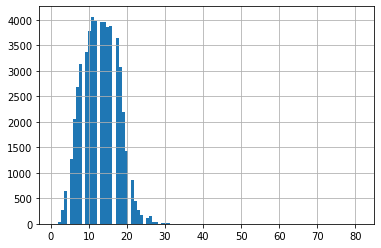

In [14]:
df_train['sentence_cut_len'] = df_train['sentence_cut'].apply(len)
df_train['sentence_cut_len'].hist(bins=100)

In [15]:
print(df_train['sentence_cut_len'].min())
print(df_train['sentence_cut_len'].max())
print(df_train['sentence_cut_len'].std())
print(df_train['sentence_cut_len'].mean())

1
81
4.5526757257246
12.904891304347826


In [33]:
(df_train['sentence_cut_len'] <= 20).sum() / len(df_train)

0.960119940029985

In [34]:
word_count_dict = defaultdict(int)

for sentence in df_train['sentence_cut']:
    for word in sentence:
        word_count_dict[word] += 1

word_count_dict = dict(list(sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)))
word_count_sort = [word for word in word_count_dict]

# Preprocessing

1. truncate
2. delete number

In [37]:
TRUNCATE_LEN = 20

def is_num(word):
    try:
        int(word)
        return True
    except:
        return False

df_train['sentence_clean'] = df_train['sentence_cut'].copy()

df_train['sentence_clean'] = df_train['sentence_clean'].apply(
    lambda sentence: [word for word in sentence if not is_num(word)])

df_train['sentence_clean'] = df_train['sentence_clean'].apply(
    lambda sentence: sentence[:TRUNCATE_LEN])


content = [''.join(x) for x in df_train['sentence_clean']]
content

['上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，',
 '商赢环球股份有限公司关于延期回复上海证券交易所对公司年年度报告的事后审核问询函的公告',
 '通过中介公司买了二手房，首付都付了，现在卖家不想卖了。怎么处理',
 '年去俄罗斯看世界杯得花多少钱？',
 '剃须刀的个性革新，雷明登天猫定制版新品首发',
 '再次证明了“无敌是多么寂寞”——逆天的中国乒乓球队！',
 '三农盾SACC-全球首个推出：互联网+区块链+农产品的电商平台',
 '重做or新英雄？其实重做对暴雪来说同样重要',
 '如何在商业活动中不受人欺骗？',
 '版红楼梦最温柔的四个丫鬟，娶谁都是一生的福气',
 '凌云研发的国产两轮电动车怎么样，有什么惊喜？',
 '房地产税迟迟无法出台？央行研究局局长徐忠这样说',
 '我四千一个月，老婆一千五一个月，存款八万且有两小孩，是先买房还是先买',
 '“产地办展”模式为“东莞制造”送创新情报',
 '全国首个央地融合平台在沪落地',
 '故事：刘主任建猪场',
 '什么是人情，什么是世故？',
 '「关注」网络自媒体不是“法外之地”，以谣博名、以谣博利将被',
 '古代先进文明的证据！这是历史上最著名的把剑',
 '加快产城融合 以科技创新引领新城区建设',
 '取名困难症患者皇马的贝尔，第一个受害者就是他的儿子',
 '夫妻间能不能互看手机？',
 '探秘、日本关东特大地震！',
 '上联：千峰入眠松涛静，怎么接下联？',
 '如何阻止基拉韦厄活火山的熔岩',
 '单硝酸异山梨酯片与硝酸异山梨酯片有何区别？',
 '廖英强被证监会处罚1.2亿，你怎么看？',
 '女儿高烧不止，我让婆婆给老公打电话回家，通话内容让我吓瘫在地',
 '上联：春风执笔谁研墨，怎么对下联？',
 '肥乡区：让文明新风吹进千家万户',
 '葫芦都能做成什么乐器？',
 '为什么袁大头等银元吹完会有响声？',
 '伊朗为什么宁愿接受制裁也不同意修改伊核协议？',
 '小白如何做好自媒体的几个信念？',
 '街头偶遇款长安CS35，颜值美炸！或售万起，还买宝骏？',
 '学生党买什么笔记本电脑好？',
 '大猩猩对镜头摆造型表情丰富，走红网络收获众多迷妹',
 '日游戏热点回顾：刺激战场：取消恶意伤害队友后，小学生开始用这种方式杀',
 '贵州多彩绚

# Tfidf Model

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [48]:
TOP_N_STOP = 3000
TAIL_N_STOP = 5000

stop_word_list = word_count_sort[:TOP_N_STOP] + word_count_sort[TAIL_N_STOP:]

tfidf = TfidfVectorizer(stop_words=stop_word_list)
X = tfidf.fit_transform(content)
X.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['001a', '05', '052d', '052e', '0pp0', '100g', '100gb', '100gift', '100km', '1050ti', '1080ti', '10at', '10g', '10gbps', '11o', '11x14', '12000km', '1200plc', '1200rs', '128g', '128gb', '12v', '12x12', '13779', '141', '1429', '145', '1525793472', '1548', '155km', '158cm', '159', '15d', '160m2', '16x16', '18q1', '1950x', '1a', '1c0', '1course', '1gb', '1k', '1mdb', '1v2', '1v3', '1w4', '200k', '2018ctcc', '2018dota2', '2018gdba', '2018ipad', '2018lg', '2018lpl', '2018met', '2018metgala', '2018msi', '2018nba', '2018p2p', '2018q1', '2018rtrv', '2019mba', '206', '209', '20g', '20w', '21d', '21x', '2575', '266', '27', '271', '275', '28t', '2900m', '2a', '2g', '2s19', '2w', '2w3', '300rmb', '30k', '30sm', '30w', '31', '310w', '320li', '33', '34', '3524', '35a', '35b', '360n', '360n7', '37', '3733', 

(53360, 100969)

['，',
 '？',
 '的',
 '！',
 '：',
 ' ',
 '了',
 '是',
 '“',
 '”',
 '你',
 '有',
 '在',
 '吗',
 '什么',
 '中国',
 '为什么',
 '如何',
 '都',
 '和',
 '怎么',
 '人',
 '不',
 '《',
 '》',
 '被',
 '、',
 '会',
 '我',
 '对',
 '美国',
 '年',
 '看',
 '上',
 '—',
 '最',
 '能',
 '这',
 '一个',
 '好',
 '要',
 '还',
 '就',
 '将',
 '后',
 '大',
 '与',
 '中',
 '让',
 '哪些',
 '他',
 '5',
 '世界',
 '去',
 '却',
 '到',
 '新',
 '谁',
 '月',
 '2018',
 '多',
 '可以',
 '说',
 '也',
 '又',
 '上联',
 '个',
 '来',
 '下联',
 '网友',
 '如果',
 '手机',
 '万',
 '做',
 '日本',
 '还是',
 '用',
 '没有',
 '现在',
 '为',
 '农村',
 '…',
 '买',
 '为何',
 '「',
 '」',
 '这个',
 '给',
 '3',
 '把',
 '呢',
 '岁',
 '怎样',
 '-',
 '多少',
 '）',
 '一',
 '10',
 '（',
 '｜',
 '很',
 '哪个',
 '国家',
 '到底',
 '知道',
 '更',
 '她',
 '真的',
 '4',
 '俄罗斯',
 '想',
 '日',
 '游戏',
 '过',
 '我们',
 '小',
 '下',
 '自己',
 '里',
 '这些',
 '钱',
 '怎么样',
 '2',
 '看待',
 '从',
 '城市',
 '这么',
 '未来',
 '1',
 '发展',
 '亿',
 '成为',
 '王者',
 '没',
 '公司',
 '汽车',
 '孩子',
 '吃',
 '打',
 '车',
 '8',
 '荣耀',
 '该',
 '活动',
 '再',
 '伊朗',
 '6',
 '出',
 '比',
 '高',
 '着',
 '旅游',
 '这样',
 '以色列',
 '才',
 '时',
 '那么'